這段代碼的主要功能是將輸入的文字轉換為語音，並將語音保存為一個音頻文件（默認為 "output_audio.wav"）。這是利用 gTTS (Google Text-to-Speech) 庫實現的。

In [ ]:
from gtts import gTTS

def text_to_speech(text, filename="output_audio.wav"):
    tts = gTTS(text=text, lang='en')
    tts.save(filename)
    print(f"Audio saved as {filename}")
    return filename

# 將輸入文字轉為語音文件
text = "The company's performance this quarter showed strong growth in revenue and profit margins, driven by increased sales and efficient cost management. Key product launches and innovations contributed to market share growth, while investments in sustainability improved both reputation and appeal to eco-conscious consumers. Employee efforts fostered a collaborative culture, which supported overall success. These results exceeded expectations, positioning the company well for future expansion into new markets."
audio_file = text_to_speech(text)

在這段代碼中，您使用了 librosa 库來提取音頻特徵，這些特徵包括：

- 零交叉率 (Zero Crossing Rate, ZCR)：它反映了音頻信號中頻率的變化，通常與音頻的粗糙度、破裂感或噪音有關。
- 頻譜質心 (Spectral Centroid)：它代表了頻譜的 "重心"，可以反映音頻的亮度或尖銳感。
- 頻譜滾降 (Spectral Roll-off)：它表示頻譜中某個特定比例的總能量位於高頻區域，這有助於識別音頻的亮度或清晰度。
- 梅爾頻率倒譜係數 (MFCCs)：這些是語音和音樂中最常用的特徵之一，用於描述音頻的頻譜特徵，能夠反映音頻的音色。

In [27]:
import librosa
import numpy as np

def extract_audio_features_with_librosa(audio_file):
    # 加载音频文件
    y, sr = librosa.load(audio_file, mono=True)
    
    # 计算特征
    zcr = np.mean(librosa.feature.zero_crossing_rate(y)[0])  # 添加 [0] 获取特征矩阵的第一行
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)[0])  # 添加 y= 和 sr=
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)[0])    # 添加 y= 和 sr=
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)  # 添加 y= 和 sr=

    # 组合特征
    features = {
        "zcr": zcr,
        "spectral_centroid": spectral_centroid,
        "spectral_rolloff": spectral_rolloff,
    }
    features.update({f"mfcc_{i+1}": mfcc for i, mfcc in enumerate(mfccs)})
    return features

# 测试代码
audio_file = "/Users/andrewhsu/Documents/FinTech_emotion/output_audio.wav"  # 替换为音频文件路径
audio_features = extract_audio_features_with_librosa(audio_file)
print("Extracted Audio Features:")
print(audio_features)

Extracted Audio Features:
{'zcr': 0.1454309971389426, 'spectral_centroid': 2382.1094134918917, 'spectral_rolloff': 4127.072314736461, 'mfcc_1': -301.59106, 'mfcc_2': 86.60667, 'mfcc_3': 2.6235971, 'mfcc_4': 9.456604, 'mfcc_5': 2.0202246, 'mfcc_6': -8.451384, 'mfcc_7': -9.348526, 'mfcc_8': -12.273613, 'mfcc_9': -9.626634, 'mfcc_10': -11.328415, 'mfcc_11': -11.634263, 'mfcc_12': -0.62094, 'mfcc_13': -6.8831778, 'mfcc_14': 2.655982, 'mfcc_15': -4.8050957, 'mfcc_16': 1.0596268, 'mfcc_17': 2.6891272, 'mfcc_18': -1.468976, 'mfcc_19': -2.6905656, 'mfcc_20': -5.8471866}


In [26]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

# 调整情绪模型的映射函数
def map_to_emotion_space(features):
    # 归一化特征值
    scaler = MinMaxScaler(feature_range=(-1, 1))
    feature_values = np.array(list(features.values())).reshape(1, -1)
    normalized_features = scaler.fit_transform(feature_values).reshape(-1)
    
    # 示例线性模型参数
    pleasure_model = LinearRegression()
    arousal_model = LinearRegression()
    
    # 手动设置合理的模型参数
    np.random.seed(42)  # 固定随机种子，保证结果一致
    pleasure_model.coef_ = np.random.uniform(-1, 1, len(normalized_features))  # 调整范围
    pleasure_model.intercept_ = 0.5  # 设置偏置
    arousal_model.coef_ = np.random.uniform(-1, 1, len(normalized_features))
    arousal_model.intercept_ = -0.5  # 设置偏置
    
    # 计算愉悦度和唤醒度
    pleasure = pleasure_model.predict([normalized_features])[0]
    arousal = arousal_model.predict([normalized_features])[0]
    
    return {"pleasure": pleasure, "arousal": arousal}

Emotion Space Mapping (Normalized):
{'pleasure': 3.1049256562692995, 'arousal': 1.4293715687766464}


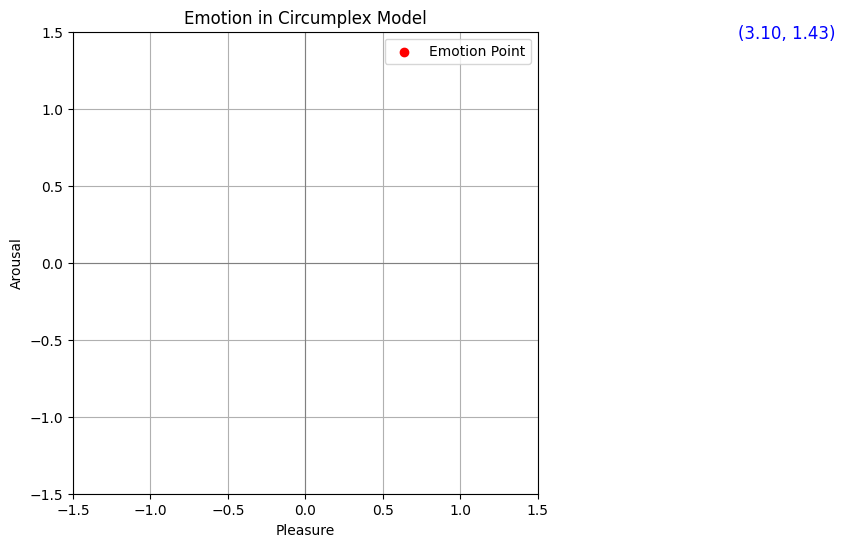

In [23]:
import matplotlib.pyplot as plt

# 绘图函数
def plot_emotion_space(emotion_space):
    pleasure = emotion_space["pleasure"]
    arousal = emotion_space["arousal"]
    
    # 绘制二维情绪空间
    plt.figure(figsize=(6, 6))
    plt.axhline(0, color='gray', linewidth=0.8)  # 横轴
    plt.axvline(0, color='gray', linewidth=0.8)  # 纵轴
    plt.scatter(pleasure, arousal, color='red', label="Emotion Point")
    plt.text(pleasure, arousal, f"({pleasure:.2f}, {arousal:.2f})", fontsize=12, color='blue', ha='center', va='bottom')
    plt.xlim(-1.5, 1.5)  # 限制 X 轴范围
    plt.ylim(-1.5, 1.5)  # 限制 Y 轴范围
    plt.xlabel("Pleasure")
    plt.ylabel("Arousal")
    plt.title("Emotion in Circumplex Model")
    plt.grid()
    plt.legend()
    plt.show()

# 执行修订流程
emotion_space = map_to_emotion_space(audio_features)
print("Emotion Space Mapping (Normalized):")
print(emotion_space)

plot_emotion_space(emotion_space)